## 1. Setup and Imports

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import pickle
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

COMPOSER_MAP = {0: 'bach', 1: 'beethoven', 2: 'debussy', 3: 'scarlatti', 4: 'victoria'}
NUM_CLASSES = len(COMPOSER_MAP)

TRAIN_DATA_PATH = 'data/train.pkl'
TEST_DATA_PATH = 'data/test_no_target.pkl'
PRED_FILE_PATH = 'pred.csv'

BATCH_SIZE = 32
VAL_PERCENT = 0.2

INPUT_SIZE = 1
HIDDEN_SIZE = 128
NUM_LAYERS = 3
BIDIRECTIONAL = True
DROPOUT_PROB = 0.5

LEARNING_RATE = 0.0001
NUM_EPOCHS = 400
WEIGHT_DECAY = 1e-5
MAX_SEQ_LEN = 2500

Using device: cuda


## 2. Load Data

In [12]:
with open(TRAIN_DATA_PATH, 'rb') as f:
    train_data_raw = pickle.load(f)

with open(TEST_DATA_PATH, 'rb') as f:
    test_sequences_raw = pickle.load(f)

print(f"Number of training samples: {len(train_data_raw)}")
print(f"Number of test samples: {len(test_sequences_raw)}")

train_sequences_raw_list = [torch.tensor(item[0], dtype=torch.float32) for item in train_data_raw]
train_labels = [torch.tensor(item[1], dtype=torch.long) for item in train_data_raw]

test_sequences_raw_list = [torch.tensor(seq, dtype=torch.float32) for seq in test_sequences_raw]

# Truncate sequences to MAX_SEQ_LEN
train_sequences = [seq[:MAX_SEQ_LEN] for seq in train_sequences_raw_list]
test_sequences = [seq[:MAX_SEQ_LEN] for seq in test_sequences_raw_list]

print(f"Number of training sequences after potential truncation: {len(train_sequences)}")
print(f"Number of test sequences after potential truncation: {len(test_sequences)}")

Number of training samples: 2939
Number of test samples: 1103
Number of training sequences after potential truncation: 2939
Number of test sequences after potential truncation: 1103


## 3. Data Analysis

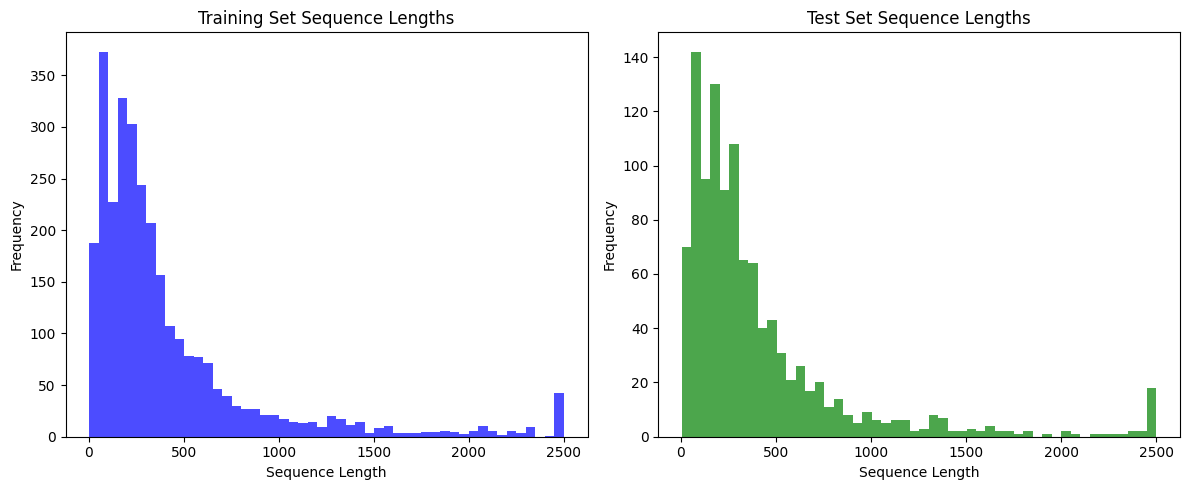

Training sequence length stats:
Min: 4, Max: 2500, Mean: 420.48, Median: 264.0

Class distribution in training data:
Class 0 (bach): 1630 samples, 55.46%
Class 1 (beethoven): 478 samples, 16.26%
Class 2 (debussy): 154 samples, 5.24%
Class 3 (scarlatti): 441 samples, 15.01%
Class 4 (victoria): 236 samples, 8.03%


In [13]:
train_seq_lengths = [len(seq) for seq in train_sequences]
test_seq_lengths = [len(seq) for seq in test_sequences]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(train_seq_lengths, bins=50, color='blue', alpha=0.7)
plt.title('Training Set Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(test_seq_lengths, bins=50, color='green', alpha=0.7)
plt.title('Test Set Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

print("Training sequence length stats:")
print(f"Min: {np.min(train_seq_lengths)}, Max: {np.max(train_seq_lengths)}, Mean: {np.mean(train_seq_lengths):.2f}, Median: {np.median(train_seq_lengths)}")

class_counts = Counter([label.item() for label in train_labels])
print("\nClass distribution in training data:")
for i in range(NUM_CLASSES):
    print(f"Class {i} ({COMPOSER_MAP[i]}): {class_counts[i]} samples, {class_counts[i]*100/len(train_labels):.2f}%")

## 4. Data Preprocessing

In [14]:
class VariableLenDataset(Dataset):
    def __init__(self, sequences, labels=None):
        self.sequences = sequences
        self.labels = labels
        if labels is not None:
            assert len(sequences) == len(labels), "Sequences and labels must have the same length"

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        if self.labels is not None:
            label = self.labels[idx]
            return sequence, label
        return sequence

def pad_collate(batch):
    if isinstance(batch[0], tuple):
        sequences = [item[0] for item in batch]
        labels = [item[1] for item in batch]
        is_test = False
    else:
        sequences = batch
        labels = None
        is_test = True

    seq_lens = [len(seq) for seq in sequences]
    padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=0.0)

    if is_test:
        return padded_sequences, seq_lens
    else:
        labels = torch.stack(labels)
        return padded_sequences, labels, seq_lens

In [15]:
full_train_dataset = VariableLenDataset(train_sequences, train_labels)

n_samples = len(full_train_dataset)
n_val = int(VAL_PERCENT * n_samples)
n_train = n_samples - n_val

train_dataset, val_dataset = random_split(full_train_dataset, [n_train, n_val])
test_dataset = VariableLenDataset(test_sequences)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=pad_collate)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=pad_collate)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=pad_collate)

Training samples: 2352
Validation samples: 587
Test samples: 1103


## 5. LSTM Model Definition

In [16]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, bidirectional=False, dropout_prob=0.5):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.num_directions = 2 if bidirectional else 1

        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout_prob if num_layers > 1 else 0
        )

        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size * self.num_directions, num_classes)

    def forward(self, x, x_lengths):
        x = x.unsqueeze(2)

        packed_input = pack_padded_sequence(x, x_lengths, batch_first=True, enforce_sorted=False)

        packed_output, (hn, cn) = self.lstm(packed_input)

        if self.bidirectional:
            last_hidden = torch.cat((hn[-2,:,:], hn[-1,:,:]), dim=1)
        else:
            last_hidden = hn[-1,:,:]

        out = self.dropout(last_hidden)
        out = self.fc(out)
        return out

model = LSTMClassifier(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, NUM_CLASSES, BIDIRECTIONAL, DROPOUT_PROB).to(device)
print(model)

LSTMClassifier(
  (lstm): LSTM(1, 128, num_layers=3, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=5, bias=True)
)


## 6. Training the Model

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs.data, 1)
    total = labels.size(0)
    correct = (predicted == labels).sum().item()
    return correct / total

train_losses = []
val_losses = []
val_accuracies = []

class_counts = Counter([label.item() for label in train_labels])
num_train_samples = len(train_labels)
class_weights_list = []
for i in range(NUM_CLASSES):
    if class_counts[i] > 0:
        weight = num_train_samples / (NUM_CLASSES * class_counts[i])
        class_weights_list.append(weight)
    else:
        class_weights_list.append(0)

class_weights = torch.tensor(class_weights_list, dtype=torch.float32).to(device)
print(f"Calculated class weights: {class_weights}")

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

Calculated class weights: tensor([0.3606, 1.2297, 3.8169, 1.3329, 2.4907], device='cuda:0')


Starting training...
Epoch [1/50], Train Loss: 1.5550, Val Loss: 1.5024, Val Accuracy: 0.4713
Epoch [2/50], Train Loss: 1.3912, Val Loss: 1.3874, Val Accuracy: 0.3728
Epoch [3/50], Train Loss: 1.2749, Val Loss: 1.2925, Val Accuracy: 0.5662
Epoch [4/50], Train Loss: 1.2056, Val Loss: 1.2175, Val Accuracy: 0.5649
Epoch [5/50], Train Loss: 1.1218, Val Loss: 1.2578, Val Accuracy: 0.4339
Epoch [6/50], Train Loss: 1.1070, Val Loss: 1.1713, Val Accuracy: 0.6039
Epoch [7/50], Train Loss: 1.0772, Val Loss: 1.1271, Val Accuracy: 0.5402
Epoch [8/50], Train Loss: 1.0531, Val Loss: 1.0696, Val Accuracy: 0.5718
Epoch [9/50], Train Loss: 0.9925, Val Loss: 1.0637, Val Accuracy: 0.5616
Epoch [10/50], Train Loss: 1.0127, Val Loss: 1.0910, Val Accuracy: 0.5763
Epoch [11/50], Train Loss: 0.9820, Val Loss: 1.0502, Val Accuracy: 0.5748
Epoch [12/50], Train Loss: 0.9663, Val Loss: 1.0392, Val Accuracy: 0.6092
Epoch [13/50], Train Loss: 0.9127, Val Loss: 1.0734, Val Accuracy: 0.6008
Epoch [14/50], Train Loss:

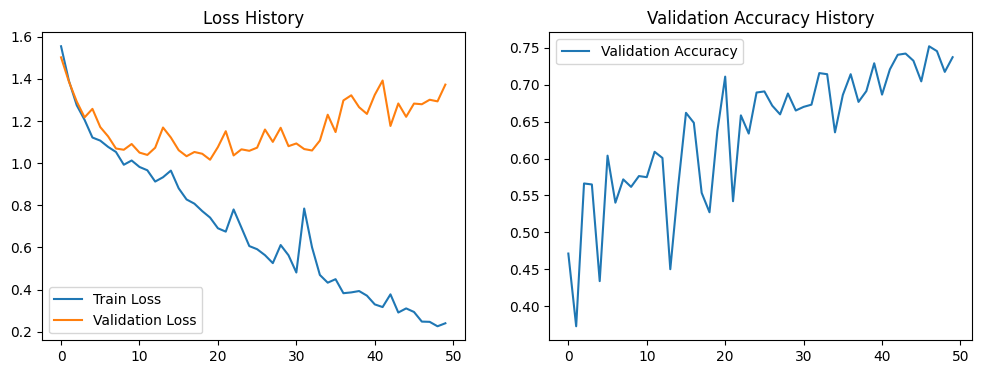

In [18]:
print("Starting training...")

for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_train_loss = 0
    for batch_idx, (sequences, labels, seq_lengths) in enumerate(train_loader):
        sequences = sequences.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(sequences, seq_lengths)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    epoch_val_loss = 0
    epoch_val_accuracy = 0
    with torch.no_grad():
        for sequences, labels, seq_lengths in val_loader:
            sequences = sequences.to(device)
            labels = labels.to(device)

            outputs = model(sequences, seq_lengths)
            loss = criterion(outputs, labels)
            epoch_val_loss += loss.item()
            epoch_val_accuracy += calculate_accuracy(outputs, labels)

    avg_val_loss = epoch_val_loss / len(val_loader)
    avg_val_accuracy = epoch_val_accuracy / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_accuracy)

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], "
          f"Train Loss: {avg_train_loss:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}, "
          f"Val Accuracy: {avg_val_accuracy:.4f}")

torch.save(model.state_dict(), 'lstm_classifier.pth')

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title('Loss History')

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend()
plt.title('Validation Accuracy History')
plt.show()

## 7. Generate Predictions for Test Set

In [19]:
model.eval()
all_predictions = []

with torch.no_grad():
    for sequences, seq_lengths in test_loader:
        sequences = sequences.to(device)

        outputs = model(sequences, seq_lengths)
        _, predicted_classes = torch.max(outputs.data, 1)
        all_predictions.extend(predicted_classes.cpu().numpy())

print(f"Generated {len(all_predictions)} predictions.")
print(f"Number of samples in test set: {len(test_dataset)}")

assert len(all_predictions) == len(test_dataset), \
    f"Mismatch in prediction count ({len(all_predictions)}) and test set size ({len(test_dataset)})"

with open(PRED_FILE_PATH, 'w') as f:
    for pred_class in all_predictions:
        f.write(f"{pred_class}\n")

print(f"Predictions saved to {PRED_FILE_PATH}")
print("\nFirst 10 predictions:", all_predictions[:10])

df_pred = pd.read_csv(PRED_FILE_PATH, header=None)
print("\nContent of pred.csv (first 5 rows):")
print(df_pred.head())
print(f"Shape of pred.csv: {df_pred.shape}")

Generated 1103 predictions.
Number of samples in test set: 1103
Predictions saved to pred.csv

First 10 predictions: [np.int64(3), np.int64(3), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(3), np.int64(0), np.int64(0), np.int64(0)]

Content of pred.csv (first 5 rows):
   0
0  3
1  3
2  0
3  0
4  0
Shape of pred.csv: (1103, 1)
